# Breast Tumout Image Segmentation and Classification


### Implementation of  U-net to localize the area which contains tumor growth (which cannot be easily determined by looking at the actual medical images) and compare it against the mask images. Then by looking at the generated mask image, classify whether the tumor growth is malignant, benign or normal.

# Importing Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import img_to_array
import os
from PIL import Image
from sklearn.model_selection import train_test_split

## Importing the images

In [4]:
path = 'drive/MyDrive/Dataset_BUSI_with_GT/'

**Helper function** to get the index for real image and mask.

In [5]:
def num (image) :
    val = 0
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    return val

##### Initialize the arrays for benign, normal and malignant tumors, both real and mask. 

In [6]:
X_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_m, y_m = np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [7]:
for i, tumor_type in enumerate(os.listdir(path)) :
    for image in os.listdir(path+tumor_type+'/') :
        p = os.path.join(path+tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # read image as  grayscale
        
        if image[-5] == ')' :
            
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                X_b[num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                           # to X as benign , normal
                X_n[num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[num(image)-1]+= img_to_array(pil_img)
        else :
            try:
              img = cv2.resize(img,(128,128))
              pil_img = Image.fromarray (img)
            except Exception as e:
              print(str(e))
            
            if image[0] == 'b' :
                y_b[num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                           # mask to y.
                y_n[num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                y_m[num(image)-1]+= img_to_array(pil_img)

#### Visualize

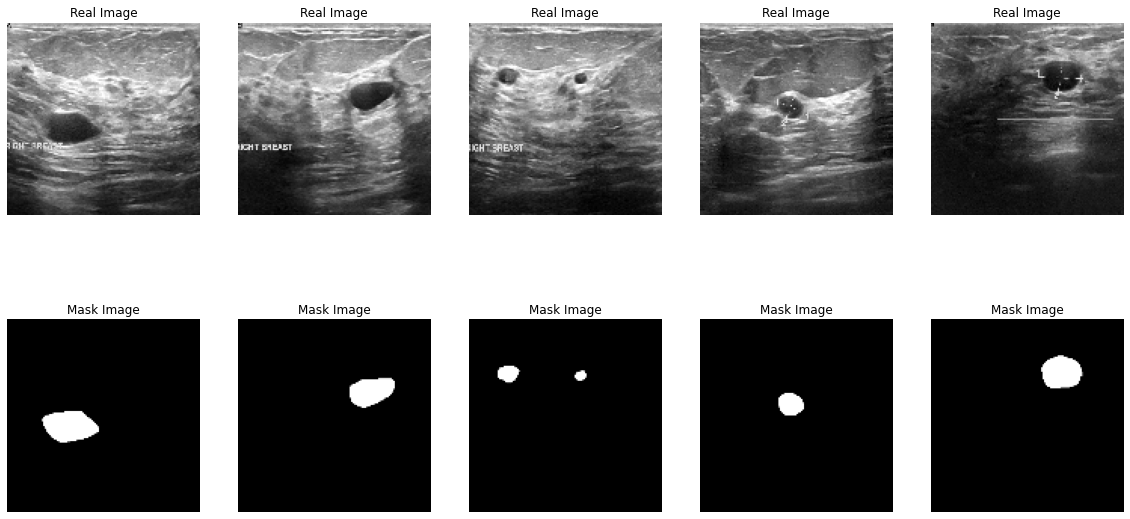

In [8]:
plt.figure(figsize = (20,10))

for i in range(5) :
    plt.subplot(2,5,i+1)
    plt.imshow(X_b[i+1].reshape(128,128), 'gray')
    plt.title('Real Image')
    plt.axis('off')

for i in range(5) :
    plt.subplot(2,5,i+6)
    plt.imshow(y_b[i+1].reshape(128,128), 'gray')
    plt.title('Mask Image')
    plt.axis('off')
plt.show()

# Creating datasets

In [9]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)
# converting to binary images
X /= 255.0
y /= 255.0

In [10]:
# looking at shapes
print(X.shape)
print(y.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


##### we have 780 images in total

In [11]:
# min and max values
print(X.max())
print(X.min())

1.0
0.0


In [12]:
print(y.max())
print(y.min())

2.0
0.0


In [13]:
# converting mask to binary
y[y > 1.0] = 1.0

In [14]:
print(y.max())
print(y.min())

1.0
0.0


# Visualization

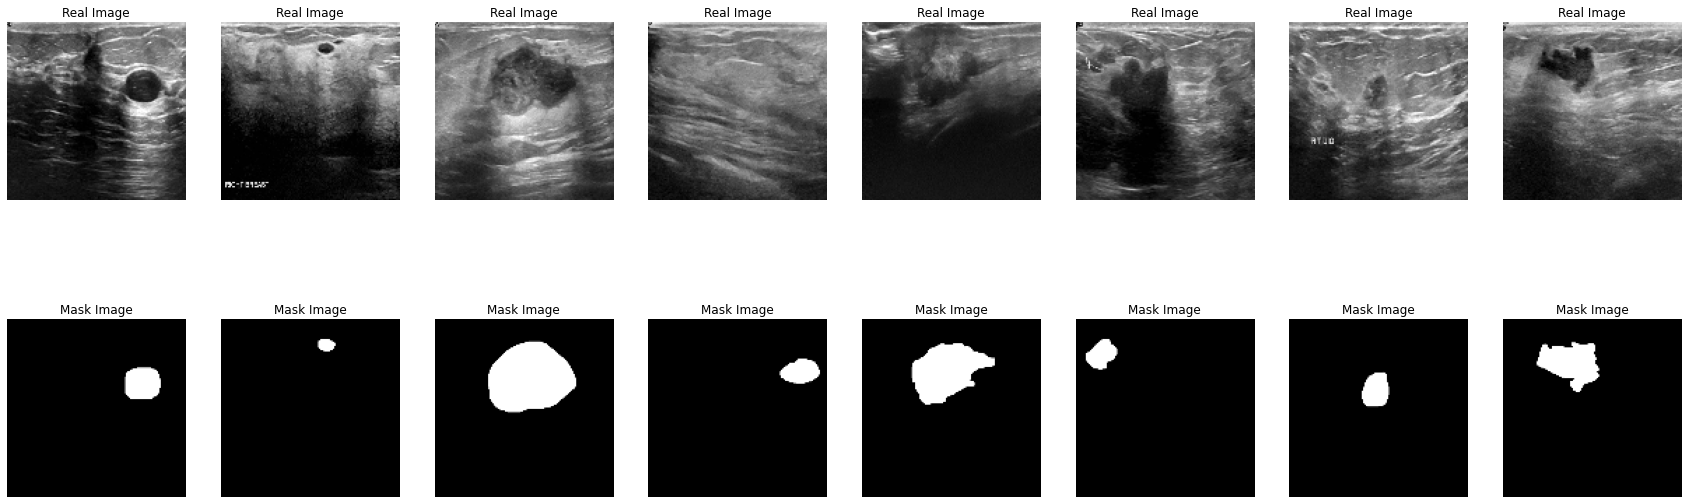

In [15]:
plt.figure(figsize = (30,10))
i = 0
while i < 8 :
    
    x = np.random.randint(0,780)
    
    plt.subplot(2,8,i+1)
    plt.imshow(X[x].reshape(128,128),'gray')
    plt.title('Real Image')
    plt.axis('off')
    
    plt.subplot(2,8,i+9)
    plt.imshow(y[x].reshape(128,128),'gray')
    plt.title('Mask Image')
    plt.axis('off')
    
    i += 1
plt.show()

### In Image 1 and Image 5, it the tumour is present but is difficult for humans to identify.

# Train test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 42)

In [17]:
print(X_train.shape)
print(y_train.shape)

(741, 128, 128, 1)
(741, 128, 128, 1)


In [18]:
print(X_test.shape)
print(y_test.shape)

(39, 128, 128, 1)
(39, 128, 128, 1)


# Model Creation U-Net


### Basic Architecture
U-net architecture can localize the area of interest. It was first used in Biomedical imaging. The reason it is able to distinguish and localize the area is by classifying every pixel in the input image. The size of input and output images is the same. 
It comprises of two paths - Contracting path and Expanding path.

### Contract Path
The Contracting path has two Convolutional layers and a Maxpooling layer.

### Expansive Path
The Expanding path consists of both transpose Convolutional layer and two Convolutional layers. The corresponding image from contracting path is fed to this layer for precise predictions.

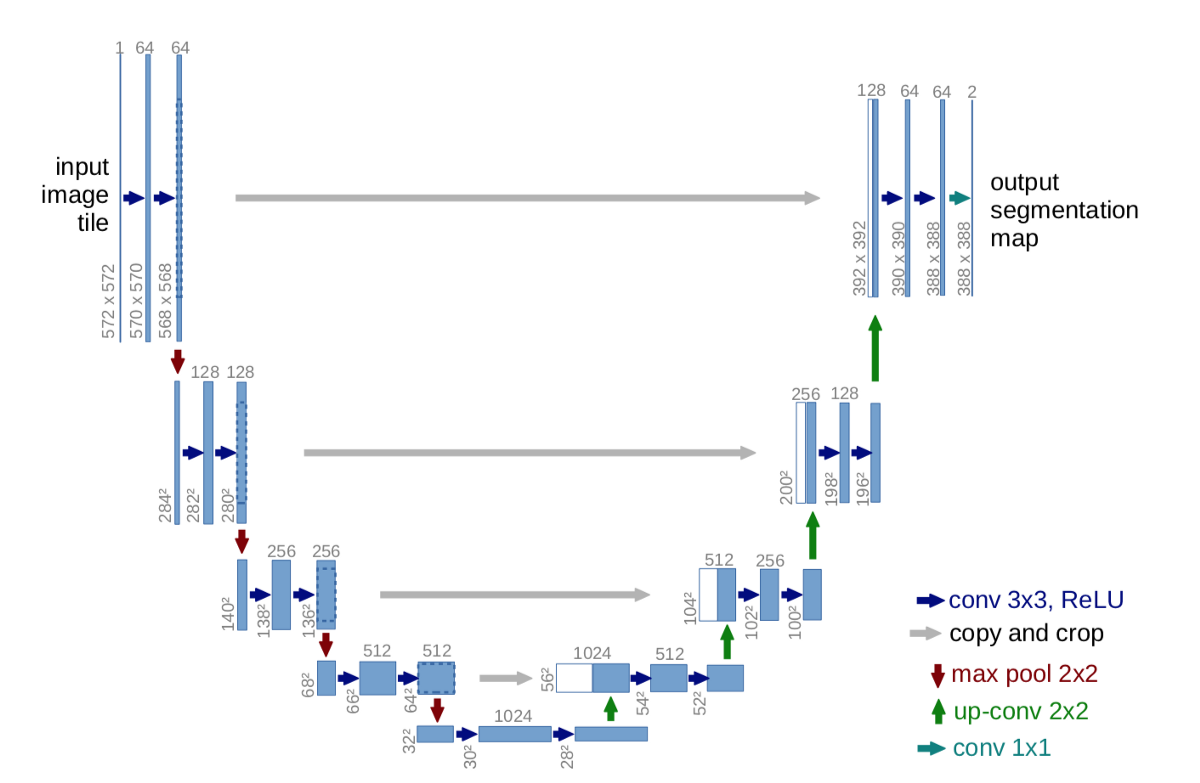

## Creating the model

In [19]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Concatenate
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose

from keras import Model

### Contracting path

In [20]:
inply = Input((128, 128, 1,))

conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(inply)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)

### Bottleneck layer

In [21]:
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)

### Expanding layer

In [22]:
tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)

In [23]:
outly = Conv2D(2**0, (1,1), activation = 'relu', padding = 'same')(drop8)
model = Model(inputs = inply, outputs = outly, name = 'U-net')

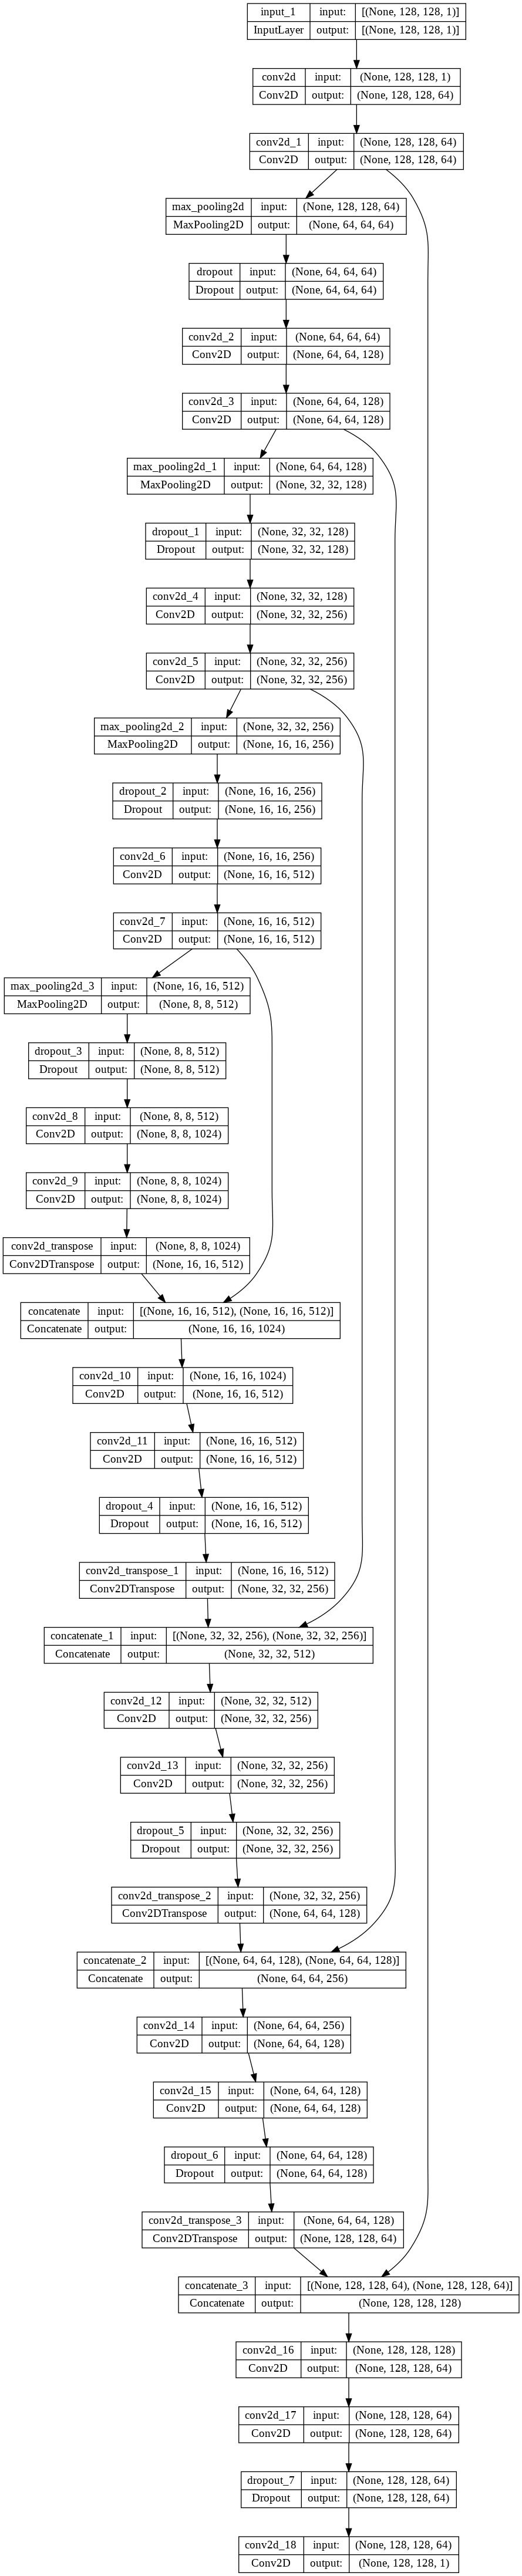

In [24]:
keras.utils.plot_model(model, './model_plot.png', show_shapes = True)

# Metrics Used

The loss for evaluating the performance of model in semantic segmentation will be IoU (Intersection over Union). It is the ratio of intersection of pixels between predicted and target image over their union. The MeanIoU() method in tf.keras.metrics package can be used.

In [25]:
from keras.metrics import MeanIoU

# Training

In [26]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005),metrics=['accuracy', MeanIoU(num_classes=3, name='IoU')])
# print(model.summary())
# model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005),metrics=[MeanIoU(num_classes=3, name='IoU')])


In [27]:
from keras.callbacks import ModelCheckpoint

In [28]:
checkp = ModelCheckpoint('./cancer_image_model.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)

In [29]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9206 - IoU: 0.4614
Epoch 1: val_loss improved from inf to 0.07223, saving model to ./cancer_image_model.h5
24/24 [==============================] - 31s 627ms/step - loss: 0.0748 - accuracy: 0.9206 - IoU: 0.4614 - val_loss: 0.0722 - val_accuracy: 0.9219 - val_IoU: 0.4621
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9206 - IoU: 0.4614
Epoch 2: val_loss improved from 0.07223 to 0.06966, saving model to ./cancer_image_model.h5
24/24 [==============================] - 10s 428ms/step - loss: 0.0727 - accuracy: 0.9206 - IoU: 0.4614 - val_loss: 0.0697 - val_accuracy: 0.9219 - val_IoU: 0.4621
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 0.9206 - IoU: 0.4614
Epoch 3: val_loss did not improve from 0.06966
24/24 [==============================] - 9s 381ms/step - loss: 0.0680 - accuracy: 0.9206 - IoU: 0.4614 - val_loss: 0.0

# Model Performance

Text(0.5, 1.0, 'Losses vs Epochs')

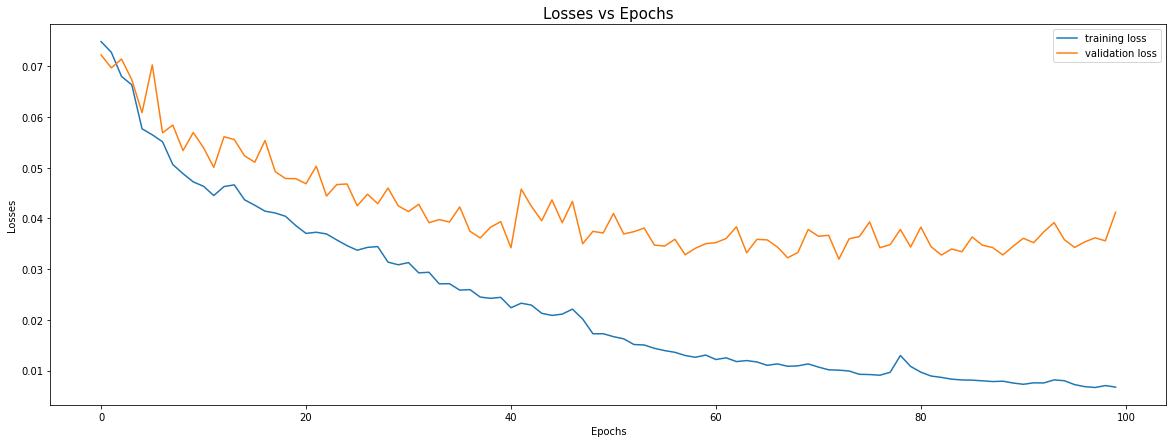

In [30]:
plt.figure(figsize = (20,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Losses vs Epochs', fontsize = 15)

In [31]:
from keras.models import load_model
model = load_model('./cancer_image_model.h5')

In [32]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 173ms/step


In [33]:
print(y_pred.shape)

(39, 128, 128, 1)


# Predictions

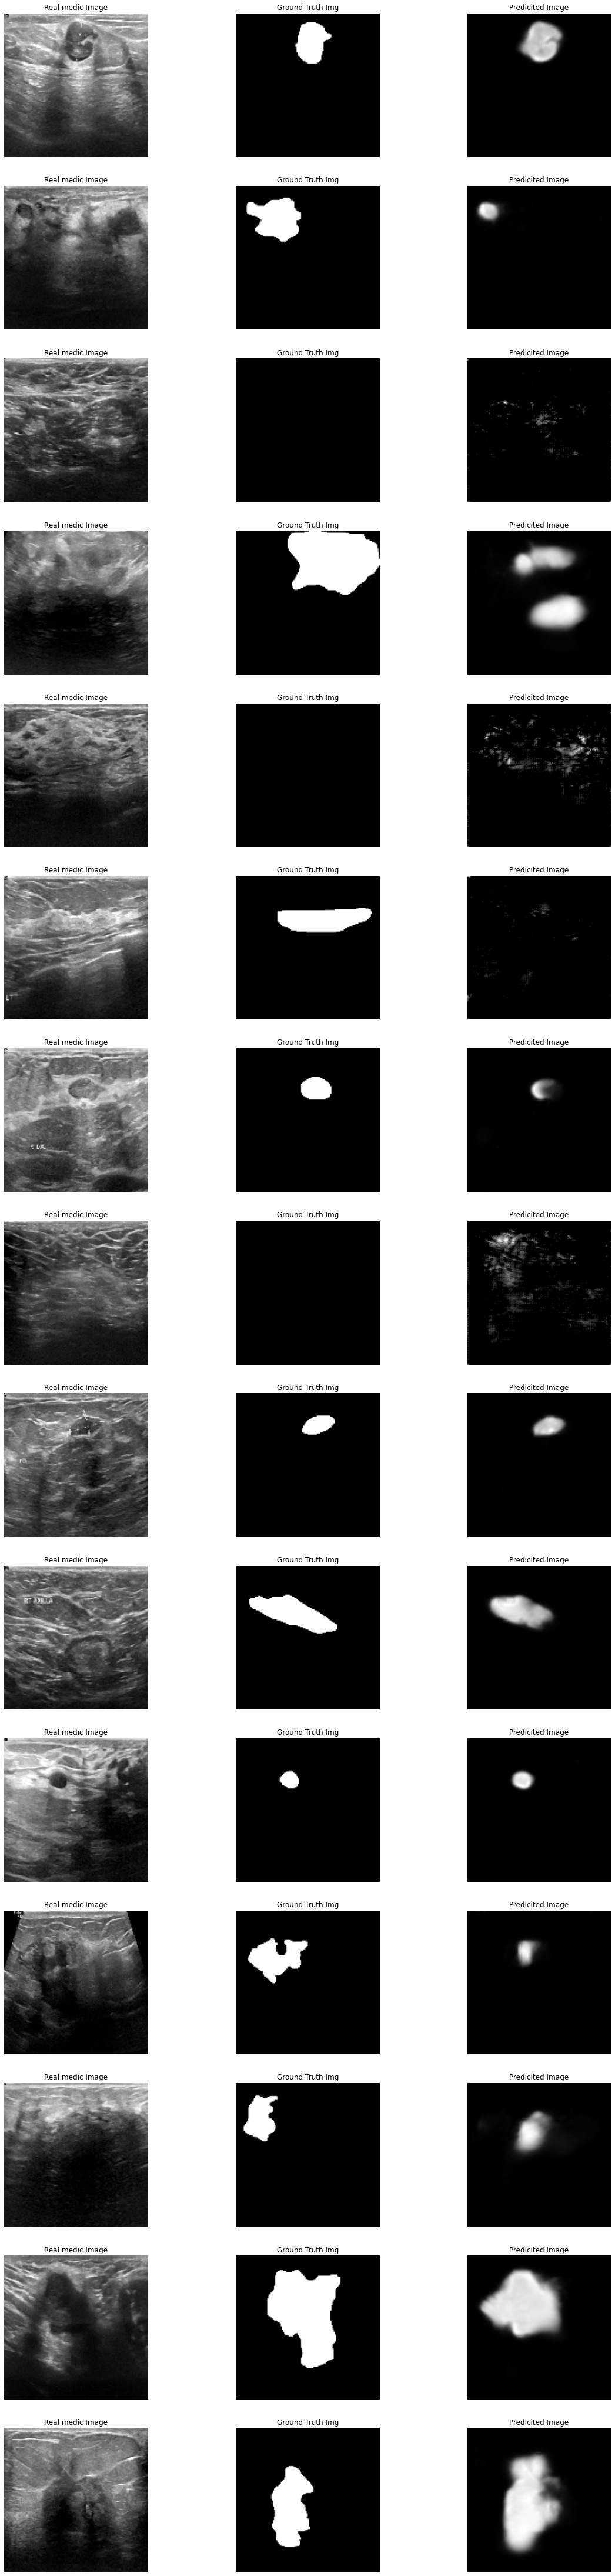

In [34]:
plt.figure(figsize = (20,80))

i = 0
x = 0
while i < 45 :
    
    plt.subplot(15,3,i+1)
    plt.imshow(X_test[x].reshape(128,128), 'gray')
    plt.title('Real medic Image')
    plt.axis('off')
    
    plt.subplot(15,3,i+2)
    plt.imshow(y_test[x].reshape(128,128), 'gray')
    plt.title('Ground Truth Img')
    plt.axis('off')
    
    plt.subplot(15,3,i+3)
    plt.imshow(y_pred[x].reshape(128,128), 'gray')
    plt.title('Predicited Image')
    plt.axis('off')
    
    x += 1
    i += 3
plt.show()

# Classifier

In [35]:
info = [ 'benign'   ,  'normal'   ,  'malignant',  ]

In [36]:
path = 'drive/MyDrive/Dataset_BUSI_with_GT/'

In [37]:
X = []
y = []

label_num = -1

for label_class in os.listdir(path) :
    
    new_path   = path + label_class
    label_num += 1
    
    for img in os.listdir(new_path) :
        if 'mask' not in img :
            
            y.append(label_num)
            x = cv2.imread(path + label_class +'/'+img, cv2.IMREAD_GRAYSCALE)
            X.append(img_to_array(Image.fromarray(cv2.resize(x, (128,128)))))

In [38]:
X = np.array(X)
y = np.array(y)

In [39]:
X/= 255.0 # converting to binary

In [40]:
from tensorflow.keras.utils import to_categorical

In [41]:
y = to_categorical(y)

In [42]:
print(X.shape)
print(y.shape)

(780, 128, 128, 1)
(780, 3)


In [43]:
print(X.min())
print(X.max())

0.0
1.0


(-0.5, 127.5, 127.5, -0.5)

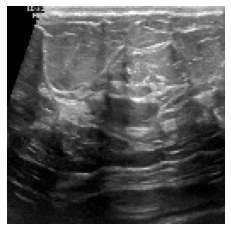

In [44]:
plt.imshow(X[0].reshape(128,128), 'gray')
plt.axis('off')

In [45]:
from keras.models import load_model

In [46]:
localize = load_model('./cancer_image_model.h5')

In [47]:
M = localize.predict(X) # generated masks

25/25 [==============================] - 5s 203ms/step


# Data distribution

In [49]:
import pandas
import seaborn

Text(0.5, 1.0, 'Distribution of classes accross the entire dataset')

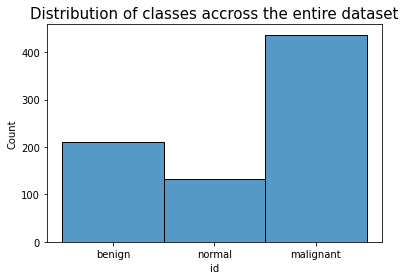

In [50]:
seaborn.histplot(data = pandas.DataFrame({'id' : [info[p] for p in np.argmax(y, axis = 1)]}), x = 'id')
plt.title('Distribution of classes accross the entire dataset', fontsize = 15)

# train-test split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(M, y, test_size = 0.1, shuffle = True, random_state = 1)

In [52]:
print(X_train.shape)
print(y_train.shape)

(702, 128, 128, 1)
(702, 3)


In [53]:
print(X_test.shape)
print(y_test.shape)

(78, 128, 128, 1)
(78, 3)


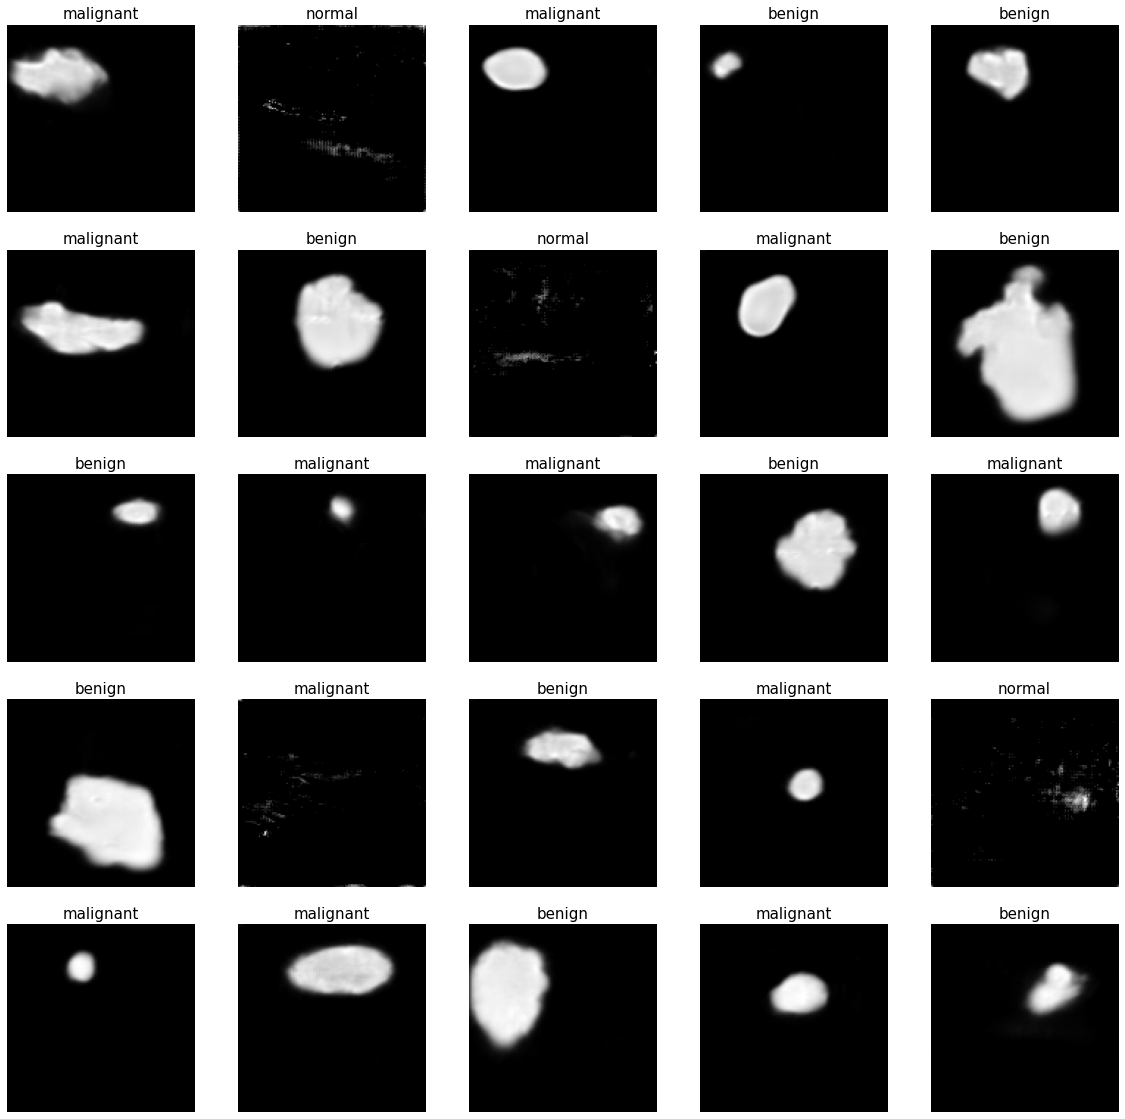

In [54]:
plt.figure(figsize = (20,20))
i = 0
SIZE = 702
while i < 25 :
    
    x = np.random.randint(0, SIZE)
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[x].reshape(128,128), 'gray')
    plt.title(f'{info[np.argmax(y_train[x])]}', fontsize = 15)
    plt.axis('off')
    
    i += 1
plt.show()

# Data augmentation

In [55]:
from keras.preprocessing.image import ImageDataGenerator

In [56]:
train_gen = ImageDataGenerator(horizontal_flip = True, rotation_range = 15, width_shift_range = [-10, 10], height_shift_range = [-10, 10], zoom_range = [0.80, 1.00])

In [57]:
train_gen.fit(X_train)

In [58]:
pointer = train_gen.flow(X_train, y_train)

In [59]:
trainX, trainy = pointer.next()

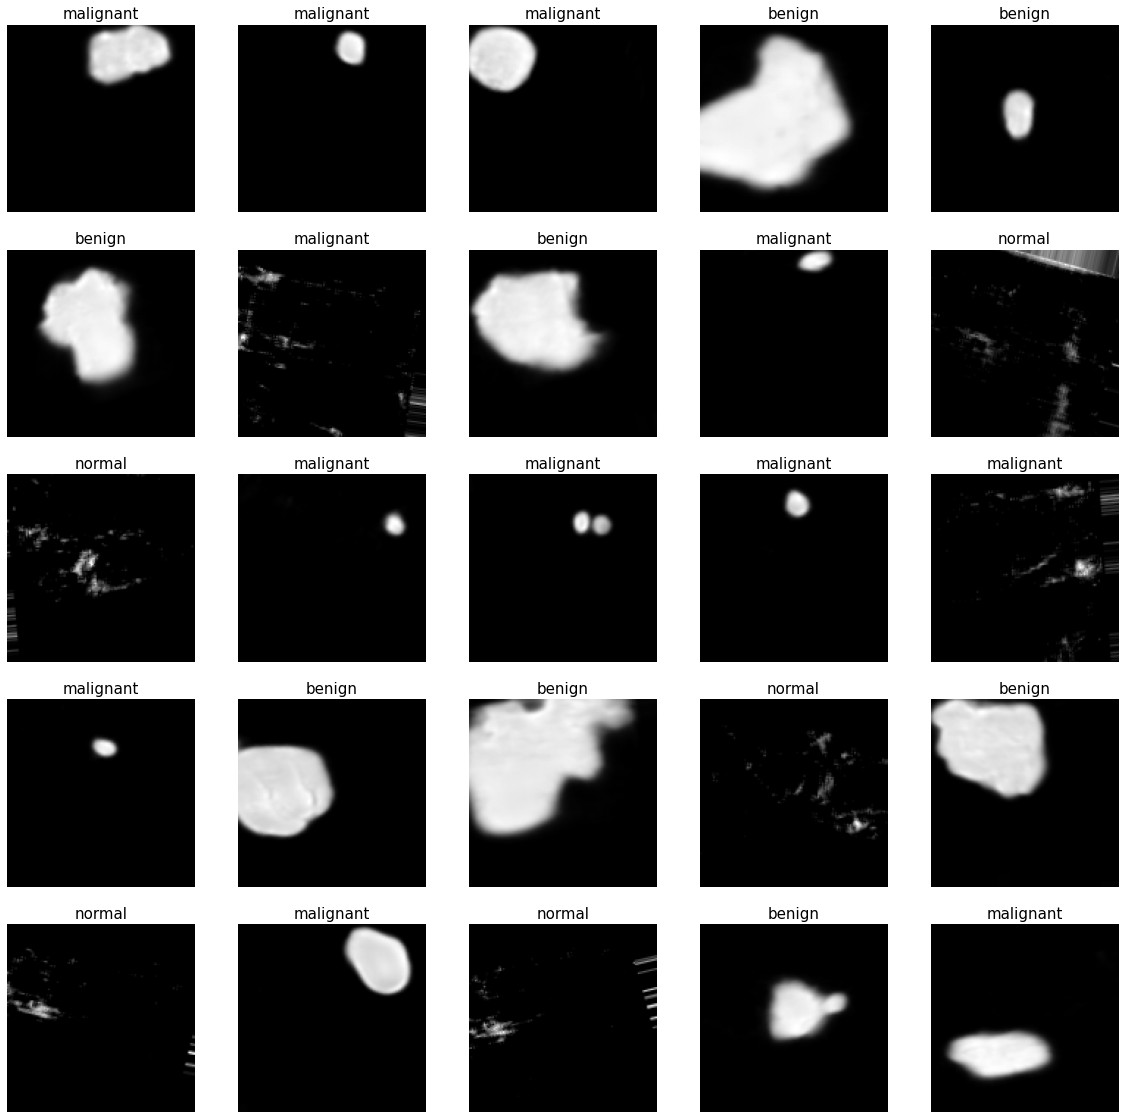

In [60]:
plt.figure(figsize = (20,20))

i = 0

while i < 25 :
    plt.subplot(5, 5, i+1)
    plt.imshow(trainX[i].reshape(128,128), 'gray')
    plt.title(f'{info[np.argmax(trainy[i])]}', fontsize = 15)
    plt.axis('off')
    
    i += 1
plt.show()

# CNN CLASSIFIER

In [61]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [62]:
def conv_block (filterx) : # function each convolution block
    
    model = Sequential()
    model.add(Conv2D(filterx, (3,3), strides = 1, padding = 'same', kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(LeakyReLU())
    model.add(MaxPooling2D())
    
    return model
########################################################################################

def dens_block (hiddenx) : # dense block
    
    model = Sequential()
    model.add(Dense(hiddenx, kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(LeakyReLU())
    
    return model
########################################################################################

def cnn (filter1, filter2, filter3, filter4, hidden1) :
    
    model = Sequential([
        
        Input((128,128,1,)),
        conv_block(filter1),
        conv_block(filter2),
        conv_block(filter3),
        conv_block(filter4),
        Flatten(),
        dens_block(hidden1),
        Dense(3, activation = 'softmax')
    ])
    
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0005), metrics = ['accuracy'])
    
    return model

In [63]:
model = cnn(32, 64, 128, 256, 32)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 32)        448       
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 64)        18752     
                                                                 
 sequential_2 (Sequential)   (None, 16, 16, 128)       74368     
                                                                 
 sequential_3 (Sequential)   (None, 8, 8, 256)         296192    
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 sequential_4 (Sequential)   (None, 32)                524448    
                                                                 
 dense_1 (Dense)             (None, 3)                

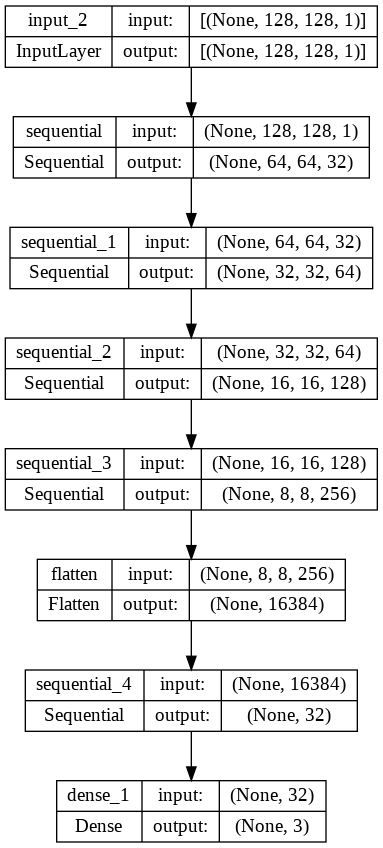

In [64]:
keras.utils.plot_model(model, 'cancer_classify.png', show_shapes = True) # plotting the model

In [65]:
checkp = ModelCheckpoint('./valid_classifier.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)

In [66]:
history = model.fit(train_gen.flow(X_train, y_train, batch_size = 64), epochs = 400, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/400
11/11 [==============================] - ETA: 0s - loss: 4.7131 - accuracy: 0.5456
Epoch 1: val_loss improved from inf to 4.63846, saving model to ./valid_classifier.h5
11/11 [==============================] - 4s 229ms/step - loss: 4.7131 - accuracy: 0.5456 - val_loss: 4.6385 - val_accuracy: 0.1538
Epoch 2/400
11/11 [==============================] - ETA: 0s - loss: 4.2784 - accuracy: 0.6553
Epoch 2: val_loss improved from 4.63846 to 4.50507, saving model to ./valid_classifier.h5
11/11 [==============================] - 1s 119ms/step - loss: 4.2784 - accuracy: 0.6553 - val_loss: 4.5051 - val_accuracy: 0.1538
Epoch 3/400
11/11 [==============================] - ETA: 0s - loss: 3.8982 - accuracy: 0.7123
Epoch 3: val_loss did not improve from 4.50507
11/11 [==============================] - 1s 106ms/step - loss: 3.8982 - accuracy: 0.7123 - val_loss: 4.5100 - val_accuracy: 0.1538
Epoch 4/400
11/11 [==============================] - ETA: 0s - loss: 3.5511 - accuracy: 0.7108
Epoc

Text(0.5, 1.0, 'Loss val wrt. Epochs')

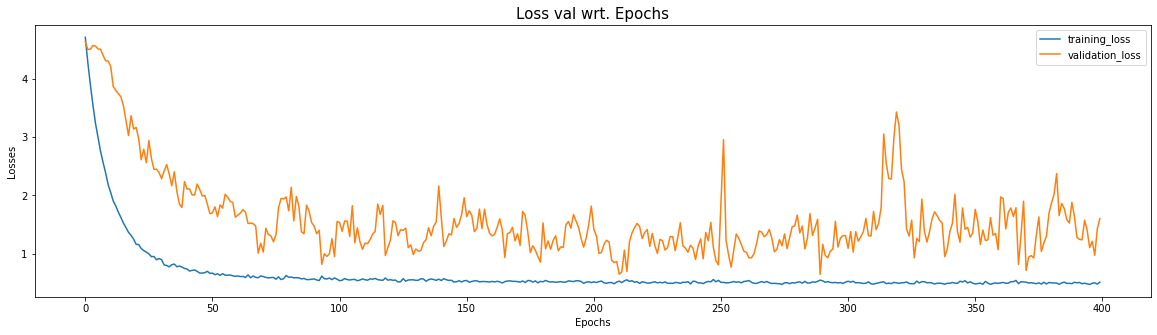

In [67]:
plt.figure(figsize = (20,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Loss val wrt. Epochs', fontsize = 15)

# Predictions

In [68]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [69]:
model = keras.models.load_model('./valid_classifier.h5')

In [70]:
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 8ms/step


In [71]:
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [72]:
print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names = info))

Accuracy : 0.8461538461538461
              precision    recall  f1-score   support

      benign       0.71      0.79      0.75        19
      normal       0.80      1.00      0.89        12
   malignant       0.93      0.83      0.88        47

    accuracy                           0.85        78
   macro avg       0.81      0.87      0.84        78
weighted avg       0.86      0.85      0.85        78



# Confusion matrix

In [73]:
cm = confusion_matrix(y_test,y_pred)

Text(0.5, 145.31999999999996, 'Predicted')

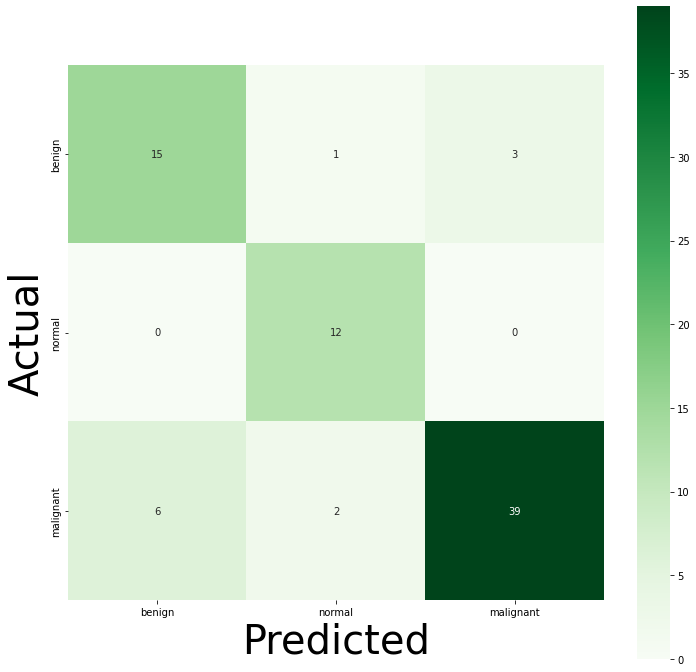

In [74]:
plt.figure(figsize = (12,12))
ax = seaborn.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels = info, yticklabels = info)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

## Testing the model 

In [75]:
image_path = [
    'drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (110).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (101).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (107).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/normal/normal (101).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/normal/normal (111).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/normal/normal (106).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (115).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (111).png',
    'drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (116).png',
]

### Loading both the models

In [76]:
from tensorflow.keras.models import load_model

In [77]:
classifier = load_model('./valid_classifier.h5')
localize = load_model('./cancer_image_model.h5')

### loading images

In [78]:
testX = []
for img in image_path :
    testX.append(img_to_array(Image.fromarray(cv2.resize(cv2.imread(img, cv2.IMREAD_GRAYSCALE), (128,128)))))

In [79]:
testX = np.array(testX)
testX/= 255.0

(-0.5, 127.5, 127.5, -0.5)

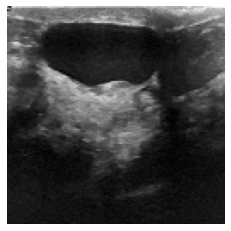

In [81]:
plt.imshow(testX[0].reshape(128,128), 'gray')
plt.axis('off')

### predict mask and label

In [82]:
predY = localize.predict(testX)

1/1 [==============================] - 2s 2s/step


(-0.5, 127.5, 127.5, -0.5)

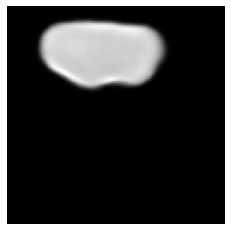

In [83]:
plt.imshow(predY[0].reshape(128,128), 'gray')
plt.axis('off')

In [84]:
pred_label = classifier.predict(predY)

1/1 [==============================] - 0s 219ms/step


### Predictions

[2 2 2 2 1 1 1 0 0 2]


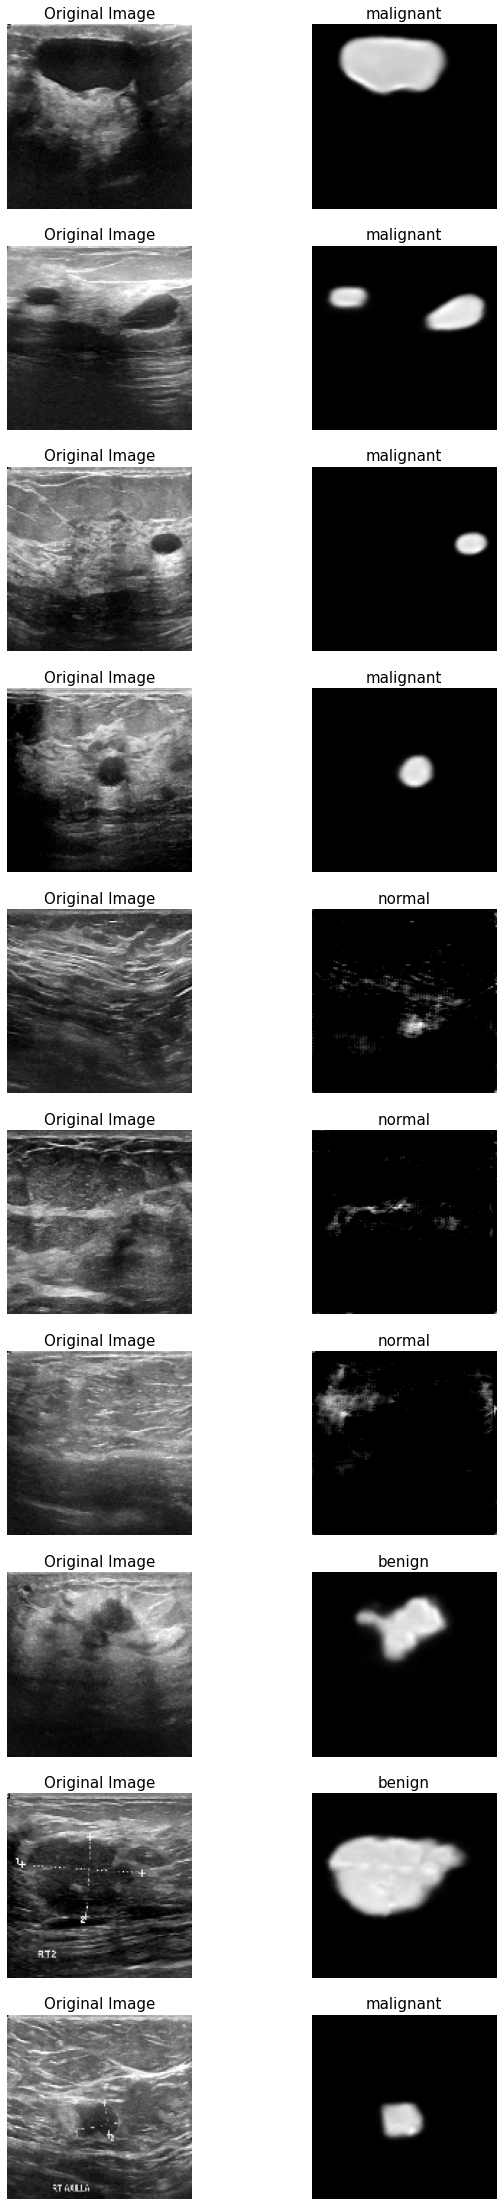

In [85]:
print(np.argmax(pred_label, axis = 1))
plt.figure(figsize = (10,40))

i = 0
j = 0
while i < 20 :
    
    plt.subplot(10,2,i+1)
    plt.imshow (testX[j].reshape(128,128), 'gray')
    plt.title('Original Image', fontsize = 15)
    plt.axis('off')
    
    plt.subplot(10,2,i+2)
    plt.imshow (predY[j].reshape(128,128), 'gray')
    plt.title(f'{info[np.argmax(pred_label[j])]}', fontsize = 15)
    plt.axis('off')
    
    j += 1
    i += 2
plt.show()